## Steady State Equation
From Sarzin; eq 40


In [7]:
from matplotlib.colors import SymLogNorm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates.sky_coordinate import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck15 as cosmo
from astropy import constants as const
from astropy.wcs import WCS
from ClusterModel import model
from ClusterModel import model_modpar
from ClusterModel import model_tools

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

In [8]:
clust = model.Cluster(name='Coma', 
                      redshift=0.023, M500=7e14*u.Msun, 
                      cosmology=cosmo, silent=True)

In [9]:
from ClusterModel.ClusterTools import cluster_electron_loss

## Understanding step by step

In [10]:
energy=np.logspace(-2,7,100)*u.GeV
radius=np.logspace(0,4,100)*u.kpc

radius, n_e = clust.get_density_gas_profile(radius)
radius, B   = clust.get_magfield_profile(radius)

dEdt = cluster_electron_loss.dEdt_tot(energy, radius=radius, n_e=n_e, B=B, redshift=clust._redshift)


emin = np.amax([(const.m_e*const.c**2).to_value('GeV'),
                        np.amin(energy.to_value('GeV'))])*u.GeV # min of CRe energy requested, or m_e c^2
emax = clust._Epmax
eng = model_tools.sampling_array(emin, emax, NptPd=clust._Npt_per_decade_integ, unit=True)


## BIG CHANGES#######################################################################
#dN_dEdVdt = clust.get_cre1_2d(eng,radius)
dN_dEdVdt= clust.get_rate_cre2(eng, radius) 
## BIG CHNGES#######################################################################


eng_grid = model_tools.replicate_array(eng, len(radius), T=True)
dN_dEdVdt_integrated = np.zeros((len(energy),len(radius))) * u.cm**-3*u.s**-1

    

for i in range(len(energy)):
            # Set out of limit values to 0
    dN_dEdVdt_i = dN_dEdVdt.copy()
    dN_dEdVdt_i[eng_grid < energy[i]] *= 0
            
            # Compute integral
    dN_dEdVdt_integrated[i,:] = model_tools.trapz_loglog(dN_dEdVdt_i, eng, axis=0)

    
energy_grid = model_tools.replicate_array(energy, len(radius), T=True)
w_neg = energy_grid <= const.m_e*const.c**2 # flag energies that are not possible
dEdt[w_neg] = 1*dEdt.unit
dN_dEdV = dN_dEdVdt_integrated / dEdt
# dN_dEdV[w_neg] = 0


In [11]:
dN_dEdV.unit

Unit("1 / (cm3 GeV)")

In [12]:
dEdt.unit

Unit("GeV / s")

In [13]:
dN_dEdVdt_i.unit

Unit("1 / (cm3 GeV s)")

In [14]:
dN_dEdVdt.unit

Unit("1 / (cm3 GeV s)")

In [15]:
dN_dEdVdt_integrated.unit

Unit("1 / (cm3 s)")

## Difference in units 

In [16]:
eng_grid.shape

(270, 100)

In [17]:
dN_dEdVdt_i.shape

(270, 100)

In [19]:
dN_dEdVdt.shape

(270, 100)

## The different functions used
- For 2ndary electrons: get rate cre2 is used
- For Coolcore solution: cre1_2d is used



## To cancel seconds in unit, I multiply get_cre1_2d by seconds
We have time dependence due to the loss function dNdt below

In [23]:
def get_cre1_2d_SS(energy=np.logspace(-2,7,100)*u.GeV, radius=np.logspace(0,4,100)*u.kpc):

        # In case the input is not an array
        energy = model_tools.check_qarray(energy, unit='GeV')
        radius = model_tools.check_qarray(radius, unit='kpc')

        # Get the necessary quantity
        radius, n_e = clust.get_density_gas_profile(radius)
        radius, B   = clust.get_magfield_profile(radius)

        # Compute the losses
        dEdt = cluster_electron_loss.dEdt_tot(energy, radius=radius, n_e=n_e, B=B, redshift=clust._redshift)

        # Get the injection rate between the and max possible, i.e. Epmax
        emin = np.amax([(const.m_e*const.c**2).to_value('GeV'),
                        np.amin(energy.to_value('GeV'))])*u.GeV # min of CRe energy requested, or m_e c^2
        emax = clust._Epmax
        eng = model_tools.sampling_array(emin, emax, NptPd=clust._Npt_per_decade_integ, unit=True)
        ### get spectrum usng momentum powerlaw by modifying model externally 

        dN_dEdVdt = clust.get_cre1_2d(eng, radius)*u.s**-1
       # dN_dEdVdt = model_tools.replicate_array(dN_dEdVdtspec, len(radius), T= True)
        eng_grid = model_tools.replicate_array(eng, len(radius), T=True)

        # Integrated cumulatively over the energy
        dN_dEdVdt_integrated = np.zeros((len(energy),len(radius))) * u.cm**-3*u.s**-1
        
        for i in range(len(energy)):
            # Set out of limit values to 0
            dN_dEdVdt_i = dN_dEdVdt.copy()
            dN_dEdVdt_i[eng_grid < energy[i]] *= 0
            
            # Compute integral
            dN_dEdVdt_integrated[i,:] = model_tools.trapz_loglog(dN_dEdVdt_i, eng, axis=0)

        # Compute the solution the equation: dN/dEdV(E,r) = 1/L(E,r) * \int_E^\infty Q(E) dE
        energy_grid = model_tools.replicate_array(energy, len(radius), T=True)
        w_neg = energy_grid <= const.m_e*const.c**2 # flag energies that are not possible
        dEdt[w_neg] = 1*dEdt.unit
        dN_dEdV = dN_dEdVdt_integrated / dEdt
        dN_dEdV[w_neg] = 0
        
        return dN_dEdV.to('GeV-1 cm-3 ')



/home/astrogamma/.local/anaconda3/envs/cta/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


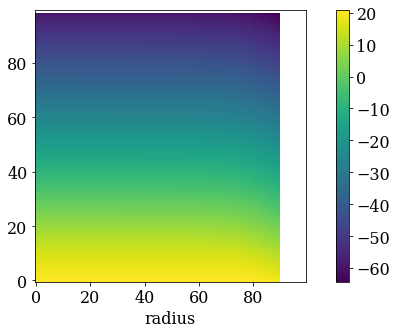

In [24]:
dndedv_try = get_cre1_2d_SS()



plt.figure(figsize=(10,5))
plt.imshow(np.log(dndedv_try.value), origin = 'lower')
plt.xlabel("radius")
plt.colorbar()



## Test from code
Again step by step

/home/astrogamma/.local/anaconda3/envs/cta/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


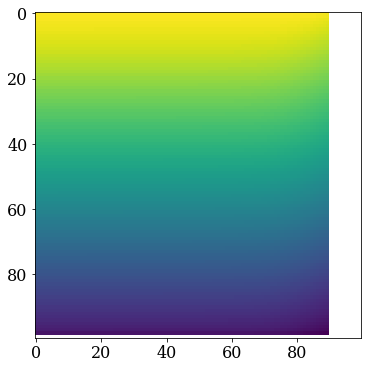

In [25]:
dnd = clust.get_cre1_2d_SS()
plt.imshow(np.log(dnd.value))

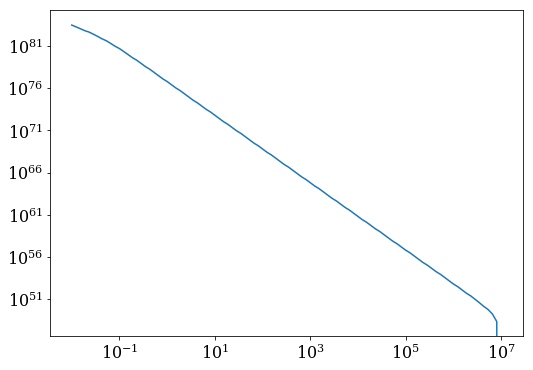

In [26]:
clust._coolcore = True
eng, dndn = clust.get_cre1_spectrum()
plt.loglog(eng,dndn)
plt.show()

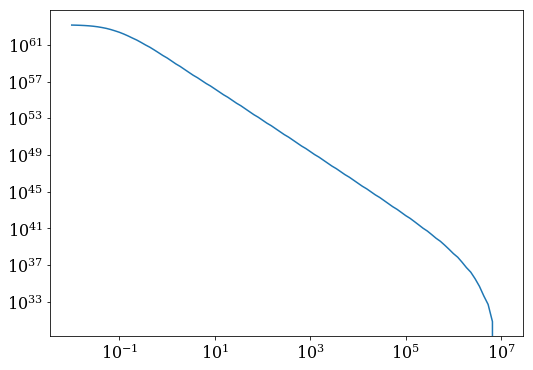

In [27]:
eng, ddd = clust.get_cre2_spectrum()
plt.loglog(eng,ddd)
plt.show()